### Part 1: Face Detection

#### 1.

In [1]:
from PIL import Image, ImageDraw
import numpy as np
import math
from scipy import signal
import scipy

In [2]:
from google.colab import drive 
drive.mount('/content/drive')
!unzip hw2.zip
!cp /content/hw2/ncc.py .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  hw2.zip
replace __MACOSX/._hw2? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
import ncc

#### 2.

In [4]:
def MakeGaussianPyramid(image, scale, minsize):
  # initialize a pyramid list
  pyramid = []

  # get the width and height of the image
  width, height = image.size

  # get the mode of the image
  mode = image.mode # "L": grayscale image; "RGB": RGB image

  # make a copy of the image
  image1 = image.copy()

  # set sigma for Gussian filter
  sigma = 1/(2*scale)

  # loop until larger dimension of the image smaller than minsize
  while max(width, height)>= minsize:
    # convert the image to a numpy array
    img_arr = np.asarray(image1).astype('float')
    # add the image to the pyramid list
    pyramid.append(img_arr)

    # initialize a array to store the filtered RGB colour channels
    blur_img_arr = np.zeros(img_arr.shape)

    if mode == "RGB":
      for channel in range(img_arr.shape[2]):
        # filter the RGB colour channels separately & then compose into a 3d array to store
        blur_img_arr[:,:,channel] = scipy.ndimage.gaussian_filter(img_arr[:,:,channel], sigma) 
    else:
      # when the image is grayscale
      blur_img_arr = scipy.ndimage.gaussian_filter(img_arr, sigma)
        
    # convert the array back to a uint8 array
    uint8_arr = blur_img_arr.astype('uint8')

    # convert the numpy array back to a PIL image
    filtered_img = Image.fromarray(uint8_arr, mode = mode)

    # reduce the width and height by a factor of scale for the next level
    width = int(width*scale)
    height = int(height*scale)

    # reduce the size of the image
    image1 = filtered_img.resize((width, height), Image.BICUBIC)

  
  return pyramid


#### 3.

In [5]:
def ShowGaussianPyramid(pyramid):
  # set the height of the output image
  height = pyramid[0].shape[0]

  # compute the width of the output image
  width = 0
  for arr in pyramid:
    width += arr.shape[1]
  
  # initialize mode
  mode = 'L'

  # if the array is 3D, change the mode
  if pyramid[0].ndim == 3:
    mode = 'RGB'

  # initialize the output image
  if mode == 'L':
    collage = Image.new(mode, (width, height), color = 255)
  else:
    collage = Image.new(mode, (width, height), 'white')

  # initialize offset
  offset = 0

  # paste existing images in pyramid into collage
  for arr in pyramid:
    # convert the nparray back to a uint8 array
    img = Image.fromarray(arr.astype('uint8'))

    collage.paste(img,(offset,0))

    # update the offset
    offset += arr.shape[1]

  # display the collage
  display(collage)

  return



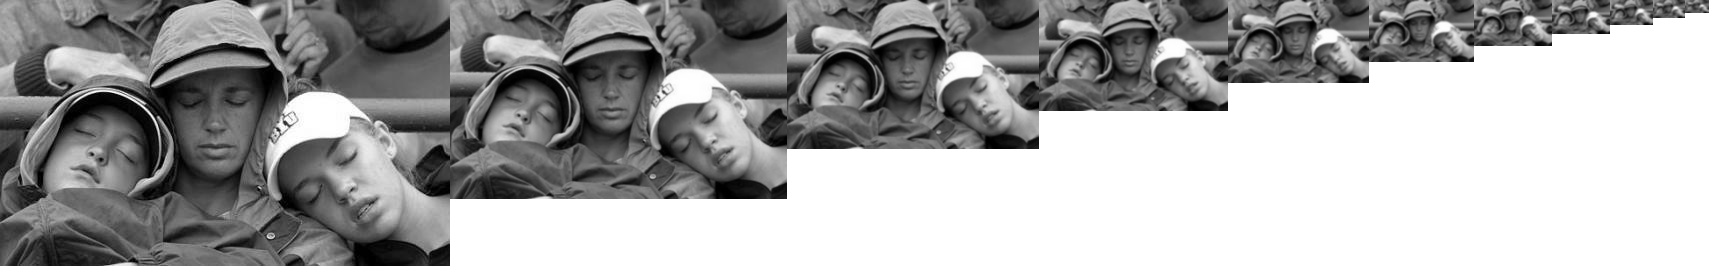

In [6]:
# Load the image
fans_image = Image.open('hw2/faces/fans.jpg')

# set minsize
minsize = 20
scale = 0.75
pyramid = MakeGaussianPyramid(fans_image, scale, minsize)
ShowGaussianPyramid(pyramid)

#### 4.

In [7]:
def FindTemplate(pyramid, template, threshold):
  # set up the template
  t_width = 15
  aspect_ratio = t_width/template.width

  # scale the height while keep the aspect ratio constant
  t_height = int(template.height * aspect_ratio)

  # resize the template
  template = template.resize((t_width,t_height), Image.BICUBIC)

  # get scale factor
  #scale = float(len(pyramid[1][0]))/len(pyramid[0][0])
  scale = 0.75

  # convert original image to a PIL image
  img = Image.fromarray(pyramid[0].astype('uint8'))
  width, height = img.size

  # convert image to RGB for displaying red box
  img = img.convert('RGB')

  # get the drawing content
  draw = ImageDraw.Draw(img)

  # initialize a counter to count number of positive results
  num_positive = 0

  for i in range(len(pyramid)):
    # compute the NCC
    imgPIL = Image.fromarray(pyramid[i].astype('uint8'))
    ncc_arr = ncc.normxcorr2D(imgPIL, template)

    # iterate over pixels of the imgPIL
    for x in range(imgPIL.width):
      for y in range(imgPIL.height):
        if ncc_arr[y,x] > threshold:
          # get the 4 points representing the box

          if t_height % 2 == 1:
            y1 = max((y - t_height // 2) / scale**i, 0) 
            y2 = min((y + t_height // 2) / scale**i, height) 
          else:
            y1 = max((y - t_height / 2) / scale**i, 0) 
            y2 = min((y + t_height / 2 + 1) / scale**i, height) 


          if t_width % 2 == 1:
            x1 = max((x - t_width // 2) / scale**i, 0) 
            x2 = min((x + t_width // 2) / scale**i, width) 
          else:
            x1 = max((x - t_width / 2) / scale**i, 0) 
            x2 = min((x + t_width / 2 + 1) / scale**i, width)

          p0 = (x1, y1)
          p1 = (x1, y2)
          p2 = (x2, y1)
          p3 = (x2, y2)

          # join the 4 vertices
          draw.line([p0, p1], fill = 'red', width = 2)
          draw.line([p2, p3], fill = 'red', width = 2)
          draw.line([p0, p2], fill = 'red', width = 2)
          draw.line([p1, p3], fill = 'red', width = 2)

          # increase number of detected faces by 1
          num_positive+= 1

  del draw
  display(img)
  print("Number of positives: ", num_positive)

  return

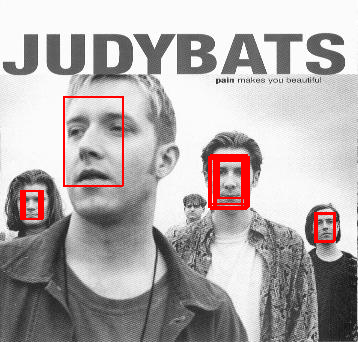

Number of positives:  18


In [29]:
# Load the template and the judybats images
template = Image.open('hw2/faces/template.jpg')
image = Image.open('hw2/faces/judybats.jpg')

# set minsize and scale
minsize = 25
scale = 0.75
pyramid = MakeGaussianPyramid(image, scale, minsize)

# set threshold
threshold = 0.66
FindTemplate(pyramid, template, threshold)

#### 5.

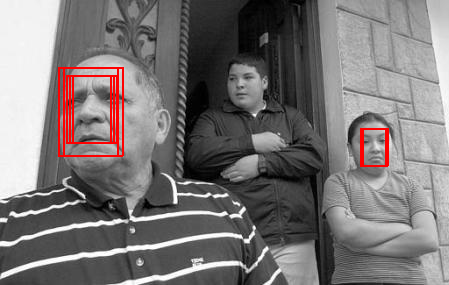

Number of positives:  7


In [31]:
# Load the images
family = Image.open('hw2/faces/family.jpg')
fans = Image.open('hw2/faces/fans.jpg')
judybats = Image.open('hw2/faces/judybats.jpg')
sports = Image.open('hw2/faces/sports.jpg')
students = Image.open('hw2/faces/students.jpg')
tree = Image.open('hw2/faces/tree.jpg')

# Make Guassian Pyramids
pyramid_family = MakeGaussianPyramid(family, scale, minsize)
pyramid_fans = MakeGaussianPyramid(fans, scale, minsize)
pyramid_judybats = MakeGaussianPyramid(judybats, scale, minsize)
pyramid_sports = MakeGaussianPyramid(sports, scale, minsize)
pyramid_students = MakeGaussianPyramid(students, scale, minsize)
pyramid_tree = MakeGaussianPyramid(tree, scale, minsize)

# set threshold
threshold = 0.61
FindTemplate(pyramid_family, template, threshold)

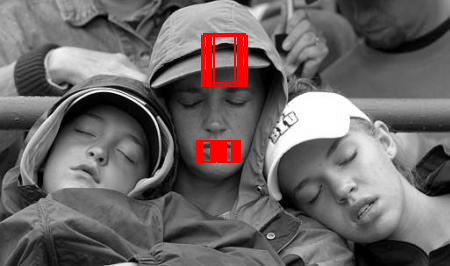

Number of positives:  25


In [32]:
FindTemplate(pyramid_fans, template, threshold)

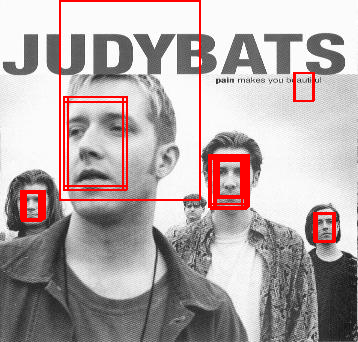

Number of positives:  33


In [33]:
FindTemplate(pyramid_judybats, template, threshold)

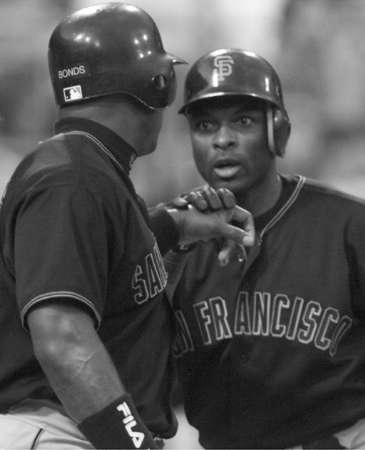

Number of positives:  0


In [34]:
FindTemplate(pyramid_sports, template, threshold)

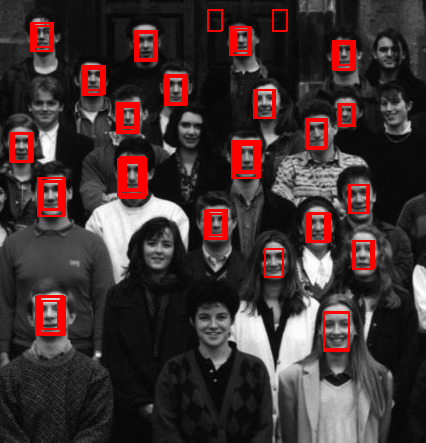

Number of positives:  142


In [35]:
FindTemplate(pyramid_students, template, threshold)

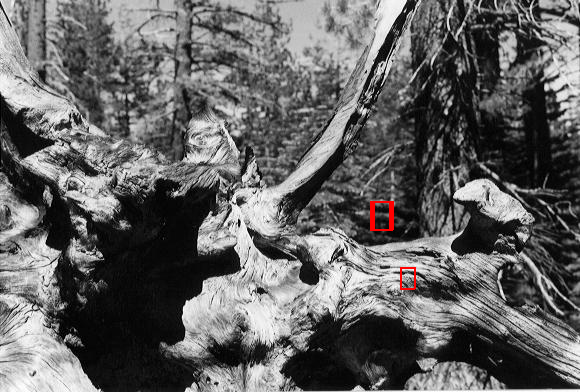

Number of positives:  4


In [36]:
FindTemplate(pyramid_tree, template, threshold)

#### 6.

- Family
  - Recall rate: $\frac{2}{3}$
  - Precision: $\frac{2}{2}$
- Fans
  - Recall rate: $0$
  - Precision: $0$
- Judybats
  - Recall rate: $\frac{4}{5}$
  - Precision: $\frac{4}{6}$
- Sports
  - Recall rate: $0$
  - Precision: $0$
- Students
  - Recall rate: $\frac{21}{27}$
  - Precision: $\frac{21}{23}$
- Tree
  - Recall rate: $0$
  - Precision: $0$


NCC method has a very low recall rate on the fans, the sports, and the tree image. 
- In the fans image, the two faces on the sides are not vertical, which have different orientations with the template face. The hat casts a shadow on face of the middle person, causing a different lighting condition with the template. Hence, NCC method performs poorly.
- In the sports image, the baseball player wears a helmet, which is a partial occlusion. In addition, the helmet casts a shadow on the player's face, thus making the face have a different lighting condition with the template face. Moreover, the template face is biased, leading to a poor results for matching faces of other ethnicities, like skin color.
- In the tree image, since there is no face, TP is always 0, thus having a low recall rate.


### Part 2: Image Blending

#### 1.

In [10]:
!unzip hw2part2.zip

Archive:  hw2part2.zip
replace __MACOSX/._hw2part2? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


#### 2.

In [11]:
def MakeLaplacianPyramid(image, scale, minsize):
  # make Gaussian pyramid
  g_pyramid = MakeGaussianPyramid(image, scale, minsize)

  # initialize Laplacian pyramid
  l_pyramid = []

  # when Gaussian pyramid <= 1 level
  if len(g_pyramid) <= 1:
    return g_pyramid
  else:
    for i in range(len(g_pyramid) - 1):
      before_blur_arr = g_pyramid[i]

      # initialize the after blur arr
      after_blur_arr = np.zeros(before_blur_arr.shape)

      # set sigma for Gussian filter
      sigma = 1/(2*scale)
      for channel in range(before_blur_arr.shape[2]):
        # filter the RGB colour channels separately & then compose into a 3d array to store
        after_blur_arr[:,:,channel] = scipy.ndimage.gaussian_filter(before_blur_arr[:,:,channel], sigma) 

      # compute residual
      residual = before_blur_arr - after_blur_arr

      l_pyramid.append(residual)

    # add the top image of Guassian pyramid
    g_top_level = g_pyramid[-1]
    l_pyramid.append(g_top_level)
    assert len(g_pyramid) == len(l_pyramid)
  
  return l_pyramid
  

#### 3.

In [12]:
def ShowLaplacianPyramid(pyramid):
  # set the height of the output image
  height = pyramid[0].shape[0]

  # compute the width of the output image
  width = 0
  for arr in pyramid:
    width += arr.shape[1]

  # initialize the output image
  collage = Image.new('RGB', (width, height), 'white')

  # initialize offset
  offset = 0

  # paste existing images in pyramid into collage
  for i in range(len(pyramid)):
    np_img = pyramid[i]

    # map the range to [0, 255], except for the lowest one
    if i != len(pyramid) - 1:
      np_img = np.clip((np_img + 128.0), 0.0, 255.0)

    # convert the nparray back to a uint8 array
    img = Image.fromarray(np_img.astype('uint8'))

    collage.paste(img,(offset,0))

    # update the offset
    offset += img.size[0]

  # display the collage
  display(collage)

  return

Laplacian pyramid for orchid image


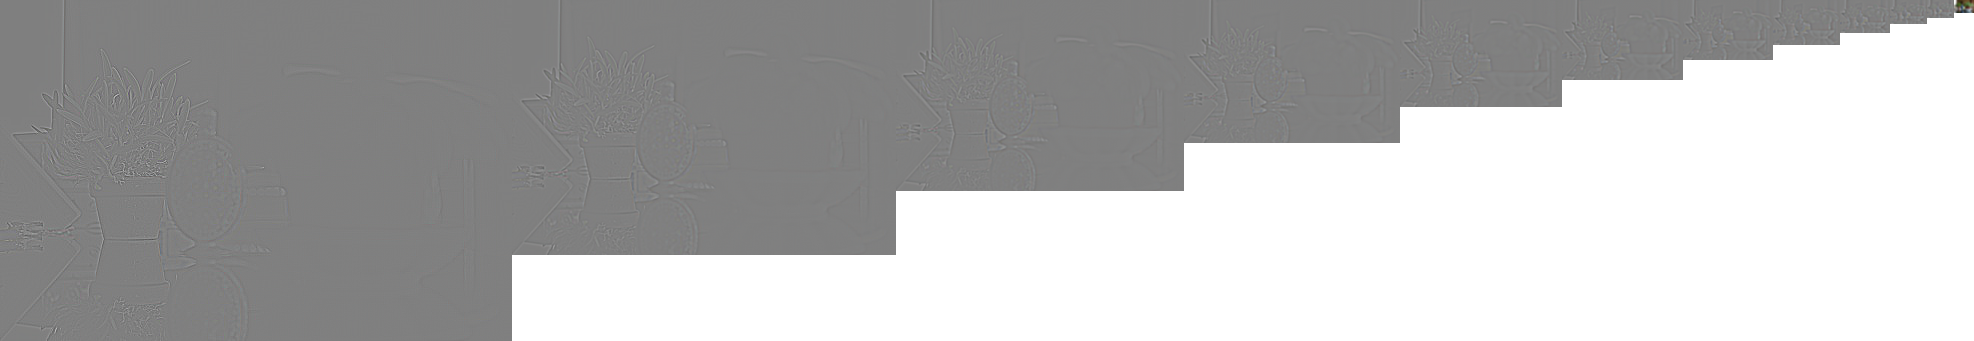

In [13]:
# set scale and minsize
scale = 0.75
minsize = 20
# Make Laplacian Pyramid for orchid and display
orchid = Image.open('/content/orchid.jpg')
l_pyramid_o = MakeLaplacianPyramid(orchid, scale, minsize)
print("Laplacian pyramid for orchid image")
ShowLaplacianPyramid(l_pyramid_o)

Laplacian pyramid for violet image


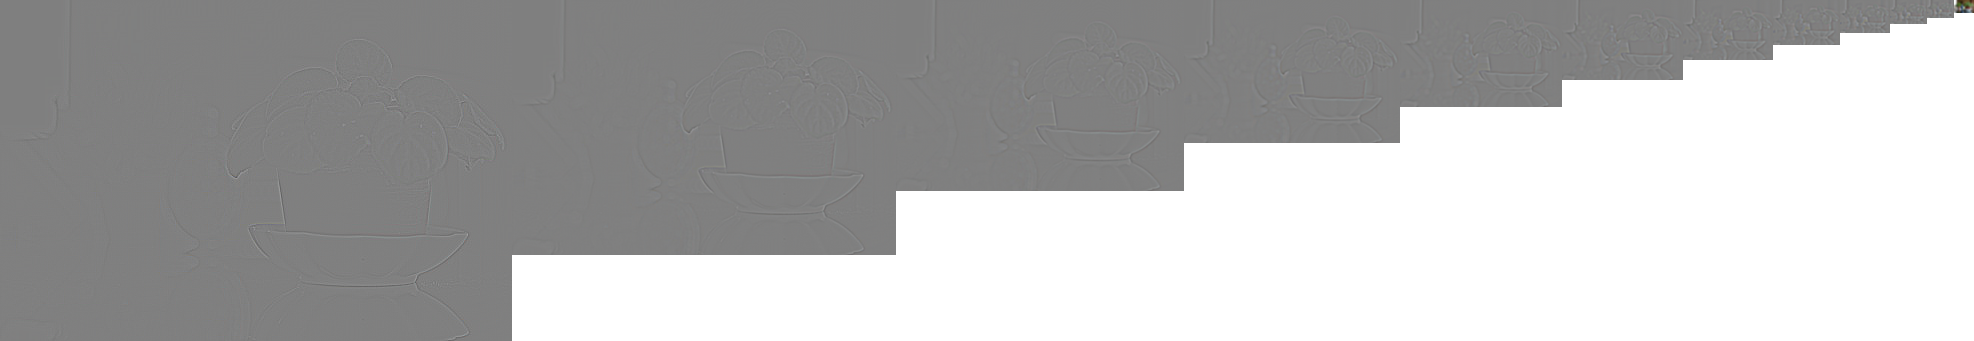

In [14]:
# Make Laplacian Pyramid for violet and displays
violet = Image.open('/content/violet.jpg')
l_pyramid_v = MakeLaplacianPyramid(violet, scale, minsize)
print("Laplacian pyramid for violet image")
ShowLaplacianPyramid(l_pyramid_v)

#### 4.

In [15]:
def ReconstructGaussianFromLaplacianPyramid(lPyramid):
  # set the scale
  scale = 0.75

  # initialize Gaussian pyramid
  gPyramid = []

  # add the top image of Laplacian pyramid to g_pyramid
  l_top_level = lPyramid[-1]
  gPyramid.append(l_top_level)

  # set sigma for Gussian filter
  sigma = 1/(2*scale)

  # from top to bottom
  for i in range(len(lPyramid)-2, -1, -1):
    l_arr = lPyramid[i]
    height, width, c = l_arr.shape

    # upsampling the image of Gussian pyramid
    # get the current first image in the pyramid
    arr = gPyramid[0]
    
    # convert to a uint8 array
    img = Image.fromarray(arr.astype('uint8'))

    next_level_img = img.resize((width, height), Image.BICUBIC)

    # convert the image to a numpy array
    next_level_img_arr = np.asarray(next_level_img).astype('float')

    # initialize the blurred image array
    blur_arr = np.zeros(next_level_img_arr.shape)

    for channel in range(next_level_img_arr.shape[2]):
      # filter the RGB colour channels separately & then compose into a 3d array to store
      blur_arr[:,:,channel] = scipy.ndimage.gaussian_filter(next_level_img_arr[:,:,channel], sigma) 

    # reconstruct the gussian image by adding the residual and the laplacian image
    gussian_arr = blur_arr + l_arr

    # add the reconstructed image
    gPyramid.insert(0, gussian_arr)

  assert len(gPyramid) == len(lPyramid)
  
  return gPyramid


Reconstructed Gaussian pyramid for orchid image


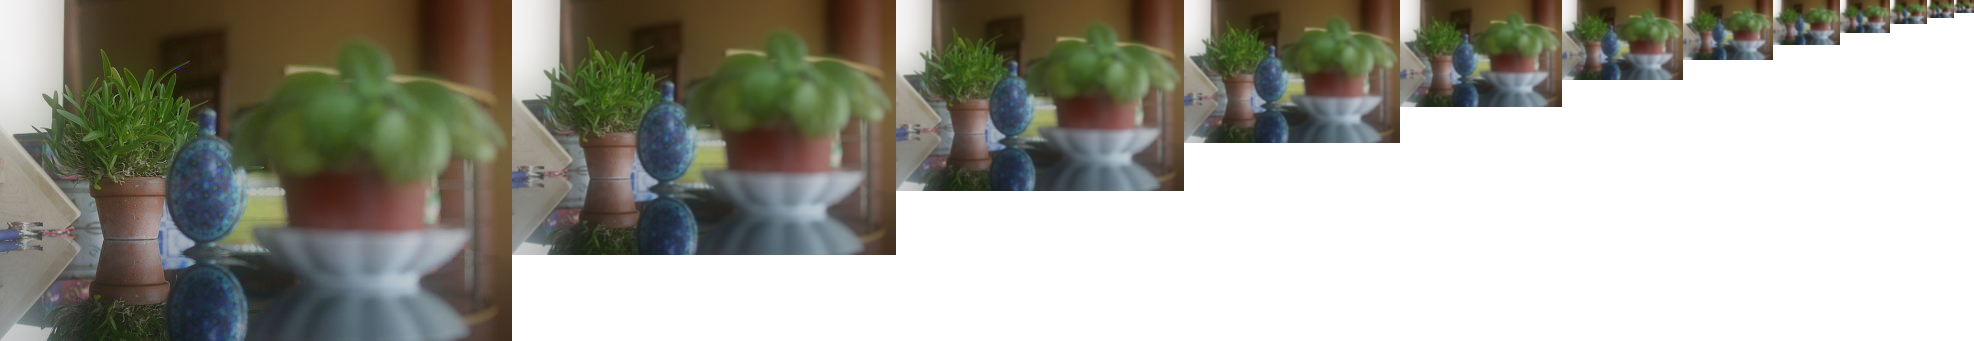

In [16]:
# Reconstruct Gaussian Pyramid for orchid and displays

# l_pyramid_o is the previous made Laplacian Pyramid for violet
gPyramid_o = ReconstructGaussianFromLaplacianPyramid(l_pyramid_o)
print("Reconstructed Gaussian pyramid for orchid image")
ShowGaussianPyramid(gPyramid_o)

Reconstructed Gaussian pyramid for violet image


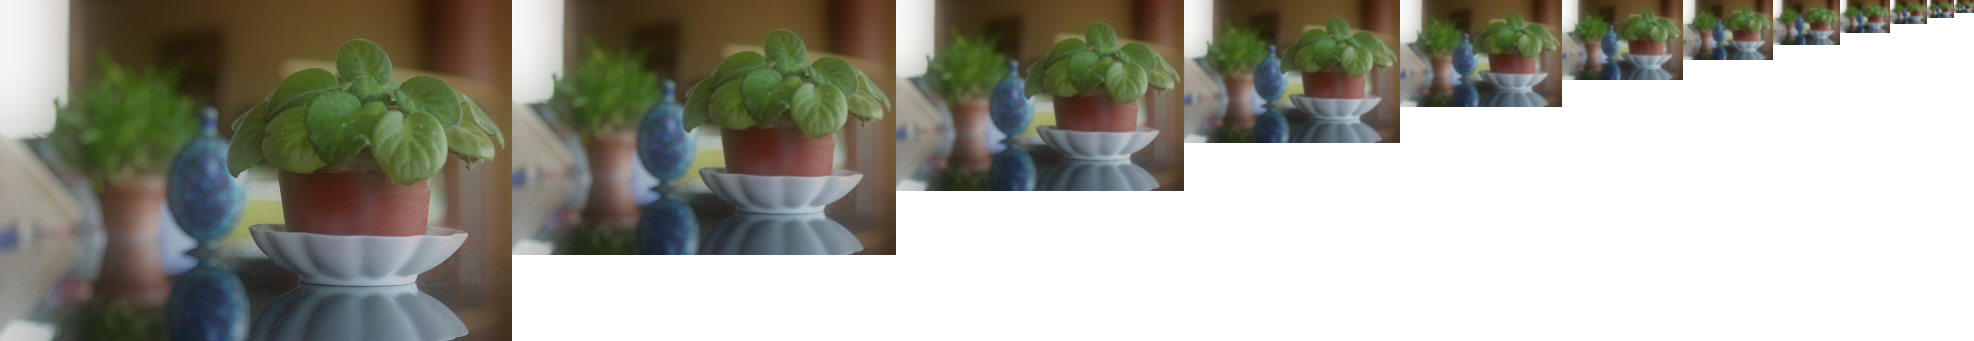

In [17]:
# Reconstruct Gaussian Pyramid for violet and displays

# l_pyramid_v is the previous made Laplacian Pyramid for violet
gPyramid_v = ReconstructGaussianFromLaplacianPyramid(l_pyramid_v)
print("Reconstructed Gaussian pyramid for violet image")
ShowGaussianPyramid(gPyramid_v)

#### 5.

Gaussian pyramid for the mask image


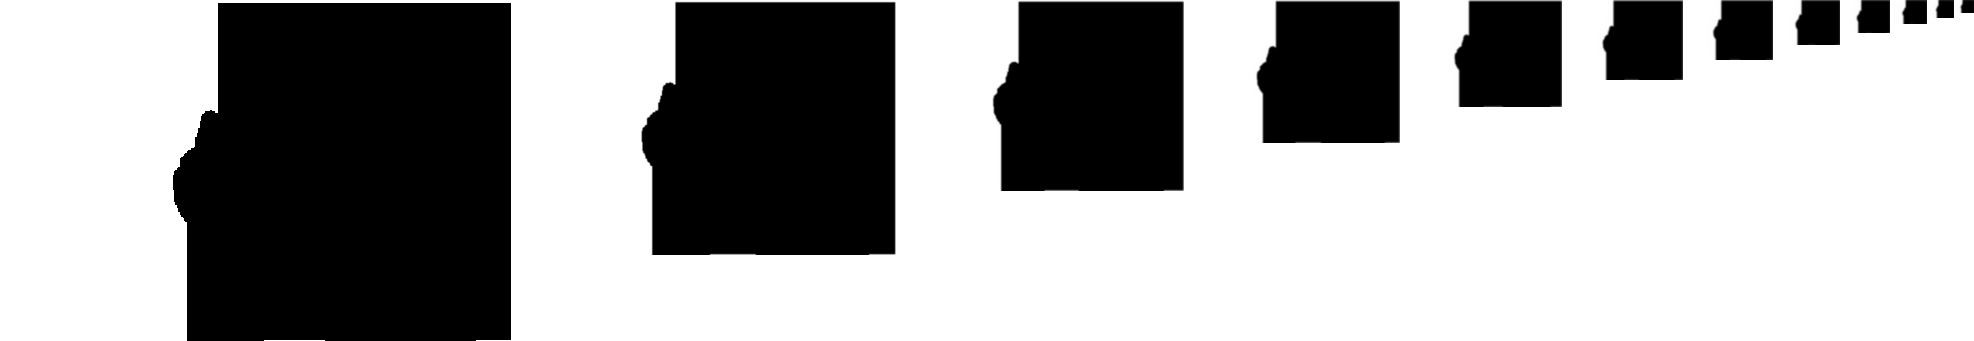

In [18]:
# Make Gaussian Pyramid for orchid mask

# set minsize
minsize = 20
scale = 0.75
orchid_mask = Image.open('/content/orchid_mask.bmp')
o_mask_gPyramid = MakeGaussianPyramid(orchid_mask, scale, minsize)
print("Gaussian pyramid for the mask image")
ShowGaussianPyramid(o_mask_gPyramid)

#### 6.

In [19]:
def blend(image1_path, image2_path, mask_path, scale, minsize):
  # Load images
  mask = Image.open(mask_path).convert('RGB')
  image1 = Image.open(image1_path)
  image2 = Image.open(image2_path)

  # Make Laplacian pyramids for image 1 and image 2
  lPyramid1 = MakeLaplacianPyramid(image1, scale, minsize)
  lPyramid2 = MakeLaplacianPyramid(image2, scale, minsize)

  # Make Gaussian pyramid for mask image
  gPyramid_m = MakeGaussianPyramid(mask, scale, minsize)

  assert len(lPyramid1) == len(lPyramid2) == len(gPyramid_m)

  
  # Make combined Laplacian pyramid
  compLaplacian = []
  for i in range(len(lPyramid1)):

    # initialize composed image arr
    com_arr = np.zeros(lPyramid1[i].shape)

    # convert the iimages to a numpy array
    imgA_arr = np.asarray(lPyramid1[i]).astype('float')
    imgB_arr = np.asarray(lPyramid2[i]).astype('float')
    imgM_arr = np.asarray(gPyramid_m[i]).astype('float')

    for channel in range(imgA_arr.shape[2]):

      # blend the RGB colour channels separately & then compose into a 3d array to store
      com_arr[:,:,channel] = imgA_arr[:,:,channel] * imgM_arr[:,:,channel]/255 +  imgB_arr[:,:,channel] * (1 - imgM_arr[:,:,channel]/255)

    compLaplacian.append(com_arr)
  

  # Construct an output Gaussian pyramid from the composed Laplacian pyramid
  gPyramid = ReconstructGaussianFromLaplacianPyramid(compLaplacian)

  # Convert the highest resolution level image array back to a uint8 array
  img_arr = np.clip(gPyramid[0], 0.0, 255.0)
  img = Image.fromarray(img_arr.astype('uint8'))

  # Display the highest resolution level image
  display(img)

  return 



Output for orchard-violet


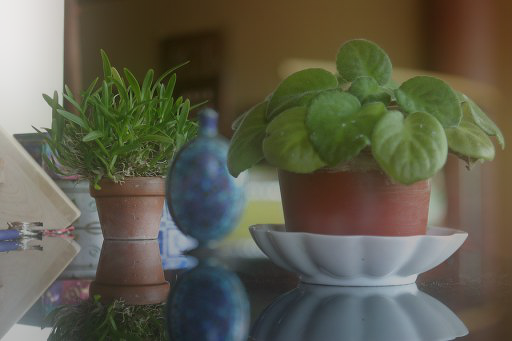

In [20]:
image1_path = "/content/orchid.jpg"
image2_path = "/content/violet.jpg"
mask_path = "/content/orchid_mask.bmp"

# set scale and minsize
scale = 0.75
minsize = 15

print('Output for orchard-violet')
blend(image1_path, image2_path, mask_path, scale, minsize)

#### 7.

Output for blue_cup-green_cup


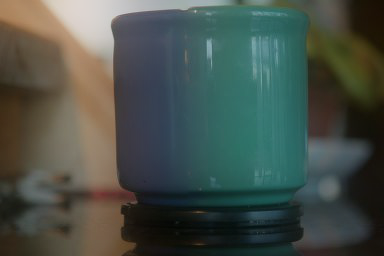

In [21]:
image1_path = "hw2part2/blue_cup.jpg"
image2_path = "hw2part2/green_cup.jpg"
mask_path = "hw2part2/cup_mask.bmp"

# set scale and minsize
scale = 0.75
minsize = 15

print('Output for blue_cup-green_cup')
blend(image1_path,image2_path,mask_path,scale,minsize)

Output for apple-tomato


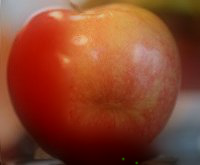

In [22]:
image1_path = "hw2part2/tomato.jpg"
image2_path = "hw2part2/apple.jpg"
mask_path = "hw2part2/tomato_mask.bmp"

# set scale and minsize
scale = 0.75
minsize = 15

print('Output for apple-tomato')
blend(image1_path,image2_path,mask_path,scale,minsize)

In [23]:
# export a PDF from the Jupyter Notebook in CoLab
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc 
!pip install pypandoc
!cp /content/drive/MyDrive/Colab\ Notebooks/Assignment2.ipynb ./

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (2.5-3build2).
texlive is already the newest version (2019.20200218-1).
texlive-latex-extra is already the newest version (2019.202000218-1).
texlive-xetex is already the newest version (2019.20200218-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!jupyter nbconvert --to PDF "Assignment2.ipynb"

[NbConvertApp] Converting notebook Assignment2.ipynb to PDF
[NbConvertApp] Support files will be in Assignment2_files/
[NbConvertApp] Making directory ./Assignment2_files
[NbConvertApp] Making directory ./Assignment2_files
[NbConvertApp] Writing 66369 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
